In [3]:
import os
import glob
from datetime import datetime
import pandas as pd
import concurrent.futures
import time
import os
import glob
import time
from datetime import datetime
import numpy as np
from scipy.optimize import curve_fit,minimize
import matplotlib.pyplot as plt


from pylidar_tls_canopy import leaf_io, plant_profile, grid, visualize
from pylidar_tls_canopy.rsmooth import rsmooth



def parse_filename(filename):
    """
    Parse a filename of the form:
      sensor_scanNumber_scanType_date-time_zenithShots_azimuthShots.csv
    For example:
      ESS00335_0001_hemi_20241009-134747Z_0800_0400.csv

    Returns a dictionary with the parsed components.
    """
    base = os.path.basename(filename)


    if base.lower().endswith(".csv"):
        base = base[:-4]  # Remove the .csv extension

    parts = base.split('_')
    if len(parts) != 6:
        raise ValueError(f"Unexpected format in filename '{filename}'. Expected 6 underscore-separated parts, got {len(parts)}.")

    sensor = parts[0]
    scan_number = parts[1]
    scan_type = parts[2]

    # The date and time are combined in the fourth part, separated by a hyphen.
    date_time_part = parts[3]
    if '-' not in date_time_part:
        raise ValueError(f"Date and time part missing '-' in filename '{filename}'.")
    date_str, time_str = date_time_part.split('-', 1)
    
    # Remove a trailing "Z" if present, then combine date and time strings.
    time_str = time_str.rstrip("Z")
    # For example, if date_str is "20241009" and time_str is "134747",
    # we create a datetime object. Adjust the format string as needed.
    dt_str = f"{date_str} {time_str}"
    dt_format = "%Y%m%d %H%M%S"
    try:
        dt_object = datetime.strptime(dt_str, dt_format)
    except Exception as e:
        raise ValueError(f"Error parsing date/time in '{filename}': {e}")

    zenith_shots = parts[4]
    azimuth_shots = parts[5]
    
    # Get file size in bytes
    file_size_bytes = os.path.getsize(filename)
    
    # Convert to KB, MB, etc.
    file_size_kb = file_size_bytes / 1024
    file_size_mb = file_size_kb / 1024

    return {
        "full_path": os.path.abspath(filename),
        "sensor": sensor,
        "scan_number": scan_number,
        "scan_type": scan_type,
        "datetime": dt_object,  # datetime object combining date and time
        "zenith_shots": zenith_shots,
        "azimuth_shots": azimuth_shots,
        "file_size_mb": file_size_mb
    }

def create_dataframe(root_dir):
    """
    Searches recursively for CSV files in the root_dir, parses their filenames,
    and returns a Pandas DataFrame containing the extracted information.
    """
    # Recursively find all CSV files in the given directory
    file_pattern = os.path.join(root_dir, "**", "*.csv")
    files = glob.glob(file_pattern, recursive=True)
    
    records = []
    for file in files:
        try:
            record = parse_filename(file)
            records.append(record)
            #print(records)
        except Exception as e:
            print(f"Skipping file {file} due to error: {e}")

    # Create DataFrame from the list of dictionaries
    df = pd.DataFrame(records)
    return df

if __name__ == "__main__":
    # Set the directory to search (adjust as needed)
    directory_to_search = "/Stor2/karun/data/benchmarking/bosland/003/D06/leaf/"  # current directory or specify your path
    df = create_dataframe(directory_to_search)



df = df.sort_values(by="datetime")


#filter out on the benchmarking scans
# Example target date as a string
targetdate = "2024-10-16"

# Convert targetdate to a date object
target_date_obj = pd.to_datetime(targetdate).date()

# Convert the time condition string to a datetime object
time_limit = pd.to_datetime("2024-10-16 15:30:30")

# Now filter the DataFrame


# df = df[
#     (df['datetime'] < time_limit) &
#     (df['datetime'].dt.date == target_date_obj)]


# excluded = ['2024-10-16 09:55:06', '2024-10-16 10:33:34']
# excluded = pd.to_datetime(excluded)

# df = df[~df['datetime'].isin(excluded)]
# df = df.reset_index(drop=True)


df


,full_path,sensor,scan_number,scan_type,datetime,zenith_shots,azimuth_shots,file_size_mb
2,/Stor2/karun/data/benchmarking/bosland/003/D06...,ESS00329,0002,hinge,2024-04-08 16:12:31,0001,8500,0.379930
1,/Stor2/karun/data/benchmarking/bosland/003/D06...,ESS00329,0003,hinge,2024-04-08 16:15:47,0003,8500,1.155030
6,/Stor2/karun/data/benchmarking/bosland/003/D06...,ESS00329,0004,hinge,2024-04-08 16:20:38,0001,8500,0.380176
3,/Stor2/karun/data/benchmarking/bosland/003/D06...,ESS00329,0005,hemi,2024-04-08 16:29:29,0200,0100,0.607923
5,/Stor2/karun/data/benchmarking/bosland/003/D06...,ESS00329,0006,hemi,2024-04-08 16:42:57,0400,0200,2.400370
0,/Stor2/karun/data/benchmarking/bosland/003/D06...,ESS00329,0007,hinge,2024-04-08 17:15:01,0005,8500,1.935226
4,/Stor2/karun/data/benchmarking/bosland/003/D06...,ESS00329,0008,hemi,2024-04-08 17:30:34,0800,0400,9.768869


In [2]:
root_dir="/Stor2/karun/data/benchmarking/leaf/berchtesgaden/004/data/"

In [4]:

def process_file(full_path, sensor, scan_number, scan_type, zenith_shots, azimuth_shots):
    
    # Example of reading a file (modify as per your file type)
    sensor_height = 1.7 # Height above ground of the sensor head (m)
    max_h = 40 # Maximum height for visualization (m)
    max_pai = None # Maximum PAI for visualization
    hres = 0.5 # Vertical resolution of profiles (m)
    zenith_offset = 0 # Fixed zenith offset for LEAF scans (rad)
    
    try:
        vpp = plant_profile.Jupp2009(hres=hres, zres=5, ares=45, min_z=5, max_z=70, min_h=0, max_h=max_h)
        valid = vpp.add_leaf_scan_position(full_path, method='FIRSTLAST', zenith_offset=zenith_offset, 
                                   min_zenith=5, max_zenith=70, sensor_height=sensor_height)
        if valid:
            vpp.get_pgap_theta_z()
            
            hinge_pai = vpp.calcHingePlantProfiles()
            hinge_pavd = vpp.get_pavd(hinge_pai)

            weighted_pai = vpp.calcSolidAnglePlantProfiles()
            weighted_pavd = vpp.get_pavd(weighted_pai)

            linear_pai = vpp.calcLinearPlantProfiles()
            linear_pavd = vpp.get_pavd(linear_pai)
         
       
        if scan_type=="hinge":
            if zenith_shots == "0005":
                scan="high_res_hinge"
            elif zenith_shots == "0003":
                scan="med_res_hinge"
            else:
                scan="low_res_hinge"
        else:
            if zenith_shots == "0800":
                scan="hi_res_hemi"
            elif zenith_shots == "0400":
                scan="med_res_hemi"
            else:
                scan="low_res_hemi"


        prof_dict = pd.DataFrame({"hinge_pai":hinge_pai, 
                    "weighted_pai":weighted_pai, 
                    "linear_pai":linear_pai, 
                    "hinge_pavd":hinge_pavd, 
                    "linear_pavd":weighted_pavd, 
                    "weighted_pavd":linear_pavd})
        
        print(f"Processed {full_path}")
        res = pd.DataFrame(prof_dict)
        
        name = "/home/kdayal/projects/pylidar-tls-canopy/results/benchmarking/bosland/003/D06/leaf/" + sensor + "_" + scan_number + "_" + scan  + ".csv" 
        
        prof_dict.to_csv(name, index=False)
        
        return prof_dict
    
    except FileNotFoundError:
        print(f"File not found: {full_path}")
        return None
    
results = df.apply(
    lambda row: process_file(row['full_path'], row['sensor'], row['scan_number'], row['scan_type'], row['zenith_shots'], row['azimuth_shots']),
    axis=1
)



Processed /Stor2/karun/data/benchmarking/bosland/003/D06/leaf/ESS00329_0002_hinge_20240408-161231Z_0001_8500.csv
Processed /Stor2/karun/data/benchmarking/bosland/003/D06/leaf/ESS00329_0003_hinge_20240408-161547Z_0003_8500.csv
Processed /Stor2/karun/data/benchmarking/bosland/003/D06/leaf/ESS00329_0004_hinge_20240408-162038Z_0001_8500.csv
Processed /Stor2/karun/data/benchmarking/bosland/003/D06/leaf/ESS00329_0005_hemi_20240408-162929Z_0200_0100.csv
Processed /Stor2/karun/data/benchmarking/bosland/003/D06/leaf/ESS00329_0006_hemi_20240408-164257Z_0400_0200.csv
Processed /Stor2/karun/data/benchmarking/bosland/003/D06/leaf/ESS00329_0007_hinge_20240408-171501Z_0005_8500.csv
Processed /Stor2/karun/data/benchmarking/bosland/003/D06/leaf/ESS00329_0008_hemi_20240408-173034Z_0800_0400.csv


0    {'hinge_pai': [-0.0, -0.0, -0.0, -0.0, -0.0, 0...
1    {'hinge_pai': [-0.0, -0.0, -0.0, -0.0, -0.0, 0...
2    {'hinge_pai': [-0.0, -0.0, -0.0, -0.0, -0.0, 0...
3    {'hinge_pai': [-0.0, -0.0, -0.0, -0.0, -0.0, 0...
4    {'hinge_pai': [-0.0, -0.0, -0.0, -0.0, -0.0, 0...
5    {'hinge_pai': [-0.0, -0.0, -0.0, -0.0, -0.0, 0...
dtype: object

In [ ]:
# Example of reading a file (modify as per your file type)
sensor_height = 1.7 # Height above ground of the sensor head (m)
max_h = 40 # Maximum height for visualization (m)
max_pai = None # Maximum PAI for visualization
hres = 0.5 # Vertical resolution of profiles (m)
zenith_offset = 0 # Fixed zenith offset for LEAF scans (rad)

leaf = '/Stor2/karun/data/benchmarking/bosland/003/D06/leaf//ESS00329_0008_hemi_20240408-173034Z_0800_0400.csv'
vpp = plant_profile.Jupp2009(hres=hres, zres=5, ares=45, min_z=5, max_z=70, min_h=0, max_h=max_h)
valid = vpp.add_leaf_scan_position(leaf, method='FIRSTLAST', zenith_offset=zenith_offset, 
                                   min_zenith=5, max_zenith=70, sensor_height=sensor_height)
vpp.get_pgap_theta_z()
            
hinge_pai = vpp.calcHingePlantProfiles()
hinge_pavd = vpp.get_pavd(hinge_pai)

weighted_pai = vpp.calcSolidAnglePlantProfiles()
weighted_pavd = vpp.get_pavd(weighted_pai)

linear_pai = vpp.calcLinearPlantProfiles()
linear_pavd = vpp.get_pavd(linear_pai)



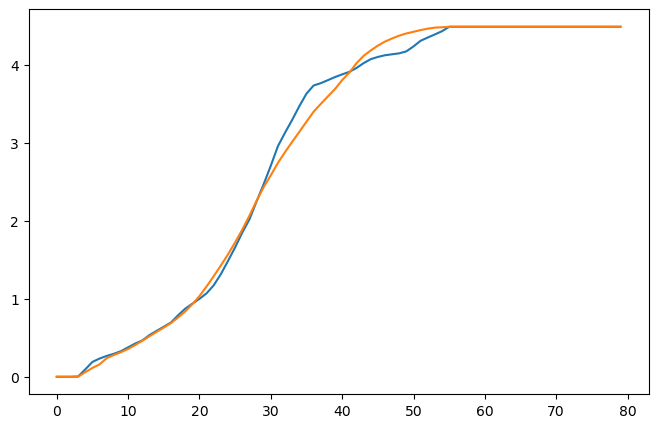

In [23]:
plt.figure(figsize=(8, 5))

plt.plot(hinge_pai)
plt.plot(weighted_pai)


In [31]:
hinge_pavd
weighted_pavd

array([0.        , 0.        , 0.00319159, 0.07678641, 0.14798996,
       0.13611648, 0.17192055, 0.16982533, 0.11072112, 0.10840252,
       0.13053033, 0.1532007 , 0.16313607, 0.16346929, 0.15847972,
       0.16006388, 0.18139259, 0.20346368, 0.22349217, 0.25405105,
       0.29885637, 0.33349358, 0.33919759, 0.34167614, 0.35276541,
       0.36521547, 0.37671152, 0.3953804 , 0.38325386, 0.32958076,
       0.29538037, 0.26836822, 0.22185517, 0.18991589, 0.18881283,
       0.18625871, 0.14840682, 0.11401867, 0.11076418, 0.13901361,
       0.14394751, 0.14964581, 0.14432355, 0.09823103, 0.07237047,
       0.0597236 , 0.04677629, 0.03772924, 0.03217766, 0.02029523,
       0.0172626 , 0.01909693, 0.01555525, 0.01056182, 0.0103077 ,
       0.00599482, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [27]:
hinge_pavd
weighted_pavd


array([0.        , 0.        , 0.00175404, 0.05898889, 0.1118951 ,
       0.10074724, 0.12498205, 0.11974994, 0.07668136, 0.07753822,
       0.0921874 , 0.1057241 , 0.11301885, 0.11400521, 0.11061341,
       0.11195265, 0.12893   , 0.14932527, 0.17035685, 0.19749456,
       0.22826453, 0.25530802, 0.26915338, 0.27948192, 0.29656972,
       0.3177803 , 0.34147596, 0.36790322, 0.36723338, 0.32882996,
       0.31060124, 0.2982327 , 0.27072573, 0.2585918 , 0.25781038,
       0.25874561, 0.22748212, 0.19644369, 0.19167481, 0.20854433,
       0.20938707, 0.2157068 , 0.21533487, 0.16433112, 0.13149852,
       0.11429202, 0.0921081 , 0.07624403, 0.06430145, 0.04908657,
       0.043307  , 0.04057144, 0.03121977, 0.01759958, 0.01101217,
       0.00636006, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     